# HAMP Data Handling

#### This script handles HAMP data from measurement state up to unified gridded data

HAMP comprises microwave radiometers with 26 channels in the frequency range 
between 20 and 183 GHz and a 35 GHz cloud radar.

#### The processing to unified grid data follows Konow et al. (2019),  https://doi.org/10.5194/essd-11-921-2019

The final  unified data from the HALO-(AC)³ campaign is published in PANGAEA under:https://doi.pangaea.de/10.1594/PANGAEA.963250

### Import

In [1]:
#major packages
import glob
import os 
import pickle
import sys

import numpy as np
import pandas as pd
import xarray as xr

import init_paths

In [2]:
ignore_warnings=True # caution this may result in hidden errors by the python packages
if ignore_warnings:
    import warnings
    warnings.filterwarnings("ignore")

In [3]:
working_path=init_paths.main()
actual_working_path=os.getcwd()+"/"
airborne_data_importer_path=working_path+"/../../Work/GIT_Repository/"+\
                            "hamp_processing_py/"+\
                                "hamp_processing_python/" # This is also the major path where your data will be stored
airborne_processing_module_path=actual_working_path+"/src/"
airborne_plotting_module_path=actual_working_path+"/plotting/"
os.chdir(airborne_processing_module_path)
sys.path.insert(1,os.getcwd())
sys.path.insert(2,airborne_plotting_module_path)
sys.path.insert(3,airborne_data_importer_path)

In [4]:
# specific configuration packages 
import config_handler
import performance
import campaign_time 

# Major processing packages
import radar_attitude
import radar_masks
import unified_grid as unigrid

## General specifications

In [6]:
campaign="HALO_AC3"
flight="RF01"
# Switches for tasks to be done by notebook. 
# Here all major performance information are given. 
# Change them if you want to select other processing steps
get_var_info                 = True
perform_raw_quicklooks       = False
perform_error_identification = False
perform_processing           = True
show_processed_results       = True

### Configuration

#### Load config class and define

In [7]:
# load config files
cfg=config_handler.Configuration(major_path=airborne_data_importer_path)#)
processing_cfg_name = "unified_grid_cfg"    
major_cfg_name      = "major_cfg"

In [8]:
# Campaign
campaign="HALO_AC3"
# Comments for data files
# Specify comment to be included into data files
comment = 'Preliminary data! Uncalibrated Data. Only use for preliminary work!'
# Specify contact information
contact = 'henning.dorff@uni-hamburg.de'

In [9]:
cfg=cfg.return_default_config_dict(major_cfg_name,processing_cfg_name,
                                   campaign,comment=comment,
                                   contact=contact)

=================== Configuration ============================
Create Config_file
Config-File  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/major_cfg.ini is created!
Create Config_file
Config-File  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/unified_grid_cfg.ini is created!
Config-file major_cfg.ini  already exists
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//major_cfg.ini
Config-file unified_grid_cfg.ini  already exists
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//unified_grid_cfg.ini
Entries:  dict_keys(['system', 'campaign_path', 'save_

## Campaign Packages

Either the flight campaign class is accessible or the flights have to be specified as shown here for EUREC4A

In [10]:
#Output file name prefix
# The usual file name will follow the format: 
# <instrument>_<date>_v<version-number>.nc
# An additional file name prefix can be specified here (e.g. for EUREC4A),

# if no prefix is necessary, set to empty string ('')
# #filenameprefix = 'EUREC4A_HALO_';
#     filenameprefix = ''
filenameprefix = campaign+'_HALO_'

In [11]:
from measurement_instruments_ql import HALO_Devices, RADAR, HAMP
try:
    import Flight_Campaign as Campaign
except:
    print("Module Flight Campaign is not listed in the path",
          "Flights need to be defined manually.")
    Flight_Dates={}
    FlightDays={}
    Flight_Dates["EUREC4A"]={"RF01":"20200119","RF02":"20200122",
                             "RF03":"20200124","RF04":"20200126",
                             "RF05":"20200128","RF06":"20200130",
                             "RF07":"20200131","RF08":"20200202",
                             "RF09":"20200205","RF10":"20200207",
                             "RF11":"20200209","RF12":"20200211",
                             "RF13":"20200213","RF14":"20200215",
                             "RF15":"20200218"}
    Flight_Dates["NAWDEX"]={} # to be filled
    Flight_Dates["NARVALII"]={} # to be filled
    Flight_Dates["NAWDEX"]={} # to be filled

    Flight_Dates["HALO_AC3"]={"RF00":"20220225",
                          "RF01":"20220311", # if this is the transfer flight
                          "RF02":"20220312",
                          "RF03":"20220313",
                          "RF04":"20220314",
                          "RF05":"20220315",
                          "RF06":"20220316",
                          "RF07":"20220320",
                          "RF08":"20220321",
                          "RF09":"20220328",
                          "RF10":"20220329",
                          "RF11":"20220330",
                          "RF12":"20220401",
                          "RF13":"20220404",
                          "RF14":"20220407",
                          "RF15":"20220408",
                          "RF16":"20220410",
                          "RF17":"20220411",
                          "RF18":"20220412"}

    FlightDays["HALO_AC3"]={"20220225":"00",
                        "20220311":"01",
                        "20220312":"02",
                        "20220313":"03"}

Module Flight Campaign is not listed in the path Flights need to be defined manually.


# Specifications

### Processing specification

In [12]:
cfg.add_entries_to_config_object(processing_cfg_name,
                        {"instruments_to_unify":["radar","radiometer"]})


Entries:  dict_keys(['instruments_to_unify']) have added to or changed in the config file


In [13]:
#Specify time frame for data conversion
start_date = Flight_Dates[campaign][flight]#'20200205'; # "20200131"  
end_date = Flight_Dates[campaign][flight]#'20200205';   # "20200205"


#### Set version information
#### Missing value
set value for missing value (pixels with no measured signal). 
This should be different from NaN, since NaN is used as fill value 
(pixels where no measurements were conducted).
Set threshold for altitude to discard radiometer data
Set threshold for roll angle to discard radiometer data



In [14]:
# Define processing steps and masking labels
cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"t1":start_date,
                                  "t2":end_date,
                                  "date":start_date,
                                  "correct_attitude":False,          # v *.1 default False, only needed for the first run
                                  "flight_date_used":start_date,
                                  "unify_Grid":True,               # v *.2 default True
                                  "remove_clutter":True,           # v *.3 default True
                                  "fill_gaps":True,                # v *.4 default True
                                  
                                  "add_radarmask":True,            # v *.5 default True
                                  "add_radar_mask_values":True,    # have to be set True if add_radarmask
                                  "remove_side_lobes":True,        # v *.6 default True
                                  "remove_radiometer_errors":True, # v *.6  default True
                                  
                                  "version":0,
                                  "subversion":6,
                                  "quicklooks":False,               # default False
                                  
                                  "missing_value":-888,
                                  "fill_value": np.nan,
                                  "altitude_threshold":4800,
                                   
                                  "roll_threshold":5})

Entries:  dict_keys(['t1', 't2', 'date', 'correct_attitude', 'flight_date_used', 'unify_Grid', 'remove_clutter', 'fill_gaps', 'add_radarmask', 'add_radar_mask_values', 'remove_side_lobes', 'remove_radiometer_errors', 'version', 'subversion', 'quicklooks', 'missing_value', 'fill_value', 'altitude_threshold', 'roll_threshold']) have added to or changed in the config file


#### Masking specification

In [15]:
#%% Define masking criteria when adding radar mask
cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"land_mask":1,"noise_mask":1,
                                  "calibration_mask":1,"surface_mask":1,
                                  "seasurface_mask":1,"num_RangeGates_for_sfc":4})

## Load config file from config class

Entries:  dict_keys(['land_mask', 'noise_mask', 'calibration_mask', 'surface_mask', 'seasurface_mask', 'num_RangeGates_for_sfc']) have added to or changed in the config file


#### Calibration specifications

In [16]:
calibrate_devices=False
if calibrate_devices:
    pass
else:
    print(campaign+" data is not on a status to be calibrated. Concerning information are still awaited.",
          "No calibration can be performed so far.")
    
cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"calibrate_radiometer":calibrate_devices,
                                  "calibrate_radar":calibrate_devices})

HALO_AC3 data is not on a status to be calibrated. Concerning information are still awaited. No calibration can be performed so far.
Entries:  dict_keys(['calibrate_radiometer', 'calibrate_radar']) have added to or changed in the config file


In [17]:
processing_config_file=cfg.load_config_file(processing_cfg_name)

processing_config_file["Input"]["data_path"]=processing_config_file["Input"][\
                                                "campaign_path"]+"Flight_Data/"
processing_config_file["Input"]["device_data_path"]=processing_config_file["Input"][\
                                                "data_path"]+campaign+"/"
prcs_cfg_dict=dict(processing_config_file["Input"])    

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//unified_grid_cfg.ini


# Start running

In [18]:
#%% Relevant flight dates
#   Specify the relevant flight dates for the period of start and end date
#   given above
prcs_cfg_dict["campaign"]=campaign
prcs_cfg_dict["Flight_Dates"]=Flight_Dates
Campaign_Time_cls=campaign_time.Campaign_Time(campaign,start_date)
flightdates_use = Campaign_Time_cls.specify_dates_to_use(prcs_cfg_dict)
# Used for later processing
prcs_cfg_dict["Flight_Dates_used"]=flightdates_use
date=flightdates_use.values[0]#"20200205"#"20200131"
flight=flightdates_use.index[0]#"RF09"#"RF07"
prcs_cfg_dict["flight"]=flight
prcs_cfg_dict["date"]=str(date)

RF00    20220225
RF01    20220311
RF02    20220312
RF03    20220313
RF04    20220314
RF05    20220315
RF06    20220316
RF07    20220320
RF08    20220321
RF09    20220328
RF10    20220329
RF11    20220330
RF12    20220401
RF13    20220404
RF14    20220407
RF15    20220408
RF16    20220410
RF17    20220411
RF18    20220412
RF19    20220414
dtype: int32


# Measurement Device Classes

In [19]:
HALO_Devices_cls=HALO_Devices(prcs_cfg_dict)
Radar_cls=RADAR(HALO_Devices_cls)
HAMP_cls=HAMP(HALO_Devices_cls)

# Raw data

### load raw data

In [20]:
# Define if you want to get variable information
get_var_info=True
#Radar

#### Radar

In [21]:
Radar_cls.open_raw_radar_data(flight,date)
raw_radar_ds=Radar_cls.raw_radar_ds

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/radar/*20220311*.nc
RADAR files for flight  RF01 : ['C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\PhD_UHH_WIMI\\my_GIT\\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/radar\\HALO-AC3_HALO_hamp_mira_20220311_RF01_prelim.nc']


In [22]:
if get_var_info:
    print(raw_radar_ds)

<xarray.Dataset>
Dimensions:          (range: 509, time: 9710)
Coordinates:
  * range            (range) float32 155.9 187.1 218.3 ... 1.596e+04 1.599e+04
  * time             (time) datetime64[ns] 2022-03-11T13:25:21 ... 2022-03-11...
Data variables: (12/50)
    nfft             int32 ...
    prf              int32 ...
    NyquistVelocity  float32 ...
    nave             int32 ...
    zrg              int32 ...
    rg0              int32 ...
    ...               ...
    MRMcx            (time) float32 ...
    RadarConst       (time) float32 ...
    SNRCorFaCo       (time, range) float32 ...
    SNRCorFaCx       (time, range) float32 ...
    SKWg             (time, range) float32 ...
    dBZg             (range, time) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    convention:        CF-1.0
    location:          Oberpfaffenhofen
    Altitude:          580m
    Latitude:          48°5'12.250"N
    Longitude:         11°16'47.250"E
    system:            HAXC
    .

#### Radiometer

In [23]:
HAMP_cls.open_raw_hamp_data()
#HAMP_cls.raw_hamp_tb_dict  # --> to show the data

Open Radiometer Channel:  KV
Open Radiometer Channel:  11990
Open Radiometer Channel:  183


#### BAHAMAS

In [24]:
######################################################################
bahamas_dir  = prcs_cfg_dict['device_data_path']+'bahamas/'
prcs_cfg_dict["bahamas_dir"]=bahamas_dir
######################################################################
# Radiometer
#prcs_cfg_dict["radarOut_dir"]=radarOut_dir

### plot raw data

In [25]:
import halodataplot
Quick_Plotter=halodataplot.Quicklook_Plotter(prcs_cfg_dict)
Radar_Quicklook=halodataplot.Radar_Quicklook(prcs_cfg_dict)
    
if perform_raw_quicklooks:
    Radar_Quicklook.plot_raw_radar_quicklook(raw_radar_ds)
    # CFAD plotting requires radar reflectivity as dataframe and 
    # then the routine plot_single_radar_cfad also calculates the cfad 
    # by executing the statusmethod "calc_radar_cfad" in Data_Plotter class
    raw_radar_reflectivity=pd.DataFrame(data=np.array(raw_radar_ds["dBZg"].T[:]),
                                        index=np.array(raw_radar_ds["time"]),
                                        columns=np.array(raw_radar_ds["range"][:]))
    Radar_Quicklook.plot_single_radar_cfad(raw_radar_reflectivity)

Typhon module cannot be loaded


In [26]:
Radiometer_Quicklook=halodataplot.Radiometer_Quicklook(prcs_cfg_dict)
Radiometer_Quicklook.radiometer_tb_dict=HAMP_cls.raw_hamp_tb_dict
if perform_raw_quicklooks:
    Radiometer_Quicklook.plot_radiometer_TBs(date,raw_measurements=True)
#Radiometer_Quicklook.radiometer_tb_dict=

## Show Calibration Coefficients

In [27]:
#Radiometer
if perform_raw_quicklooks:
    if calibrate_devices:
        Radiometer_Quicklook.plot_HAMP_TB_calibration_coeffs_of_flight()

In [28]:
#Radar
if perform_raw_quicklooks:
    if calibrate_devices:
        Radar_cls.show_calibration()

# Error Identification

In [29]:
if perform_error_identification:
    import error_identification as Error_Identification
    Error_Identification.main(function_configurated=False,
         prcs_cfg_dict=None)

# Processing

In [30]:
if perform_processing:
    print("=========================== Processing ===============================")
    """
    Radar Attitude Correction
    """
    if performance.str2bool(prcs_cfg_dict["correct_attitude"]):
        # Correct radar data for aircraft attitude
        print("Correct the radar attitude")
        radar_attitude.run_att_correction(flightdates_use, prcs_cfg_dict)

    else:
        prcs_cfg_dict["radar_outDir"]=prcs_cfg_dict["device_data_path"]+"radar_mira/"
        for flight in flightdates_use:
            # Even if explicitly desired to not attitude correct radar files,
            # it is checked here, whether the corrected-file already exists
            if len(glob.glob(prcs_cfg_dict["radar_outDir"]+"*"+str(flight)+"*.nc"))>=1:
                print("Flight is already attitude-corrected, so skip this step")
        
            else:
                new_flightdates_use=pd.Series(flight,
                              index=flightdates_use[\
                                        flightdates_use==int(flight)].index)
                radar_attitude.run_att_correction(new_flightdates_use,prcs_cfg_dict)
    
    """
    Add radar mask
    """
    if performance.str2bool(prcs_cfg_dict["add_radarmask"]):
        # Create radar info mask
        radar_masks.run_make_masks(flightdates_use, prcs_cfg_dict)
    
    """
    Run grid unification and further processing internally
    """
    if performance.str2bool(prcs_cfg_dict["unify_grid"]):
        # Unify data from bahamas, dropsondes, radar, radiometer onto common grid
        unigrid.run_unify_grid(flightdates_use,prcs_cfg_dict)

# Plotting

In [31]:
version_to_open=str(prcs_cfg_dict["version"])+"."+str(prcs_cfg_dict["subversion"])

## Processed radar

Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radar_unified_*20220311_v0*.nc
Opened specific version: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc\HALO_HALO_AC3_radar_unified_RF01_20220311_v0.2.nc
Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing

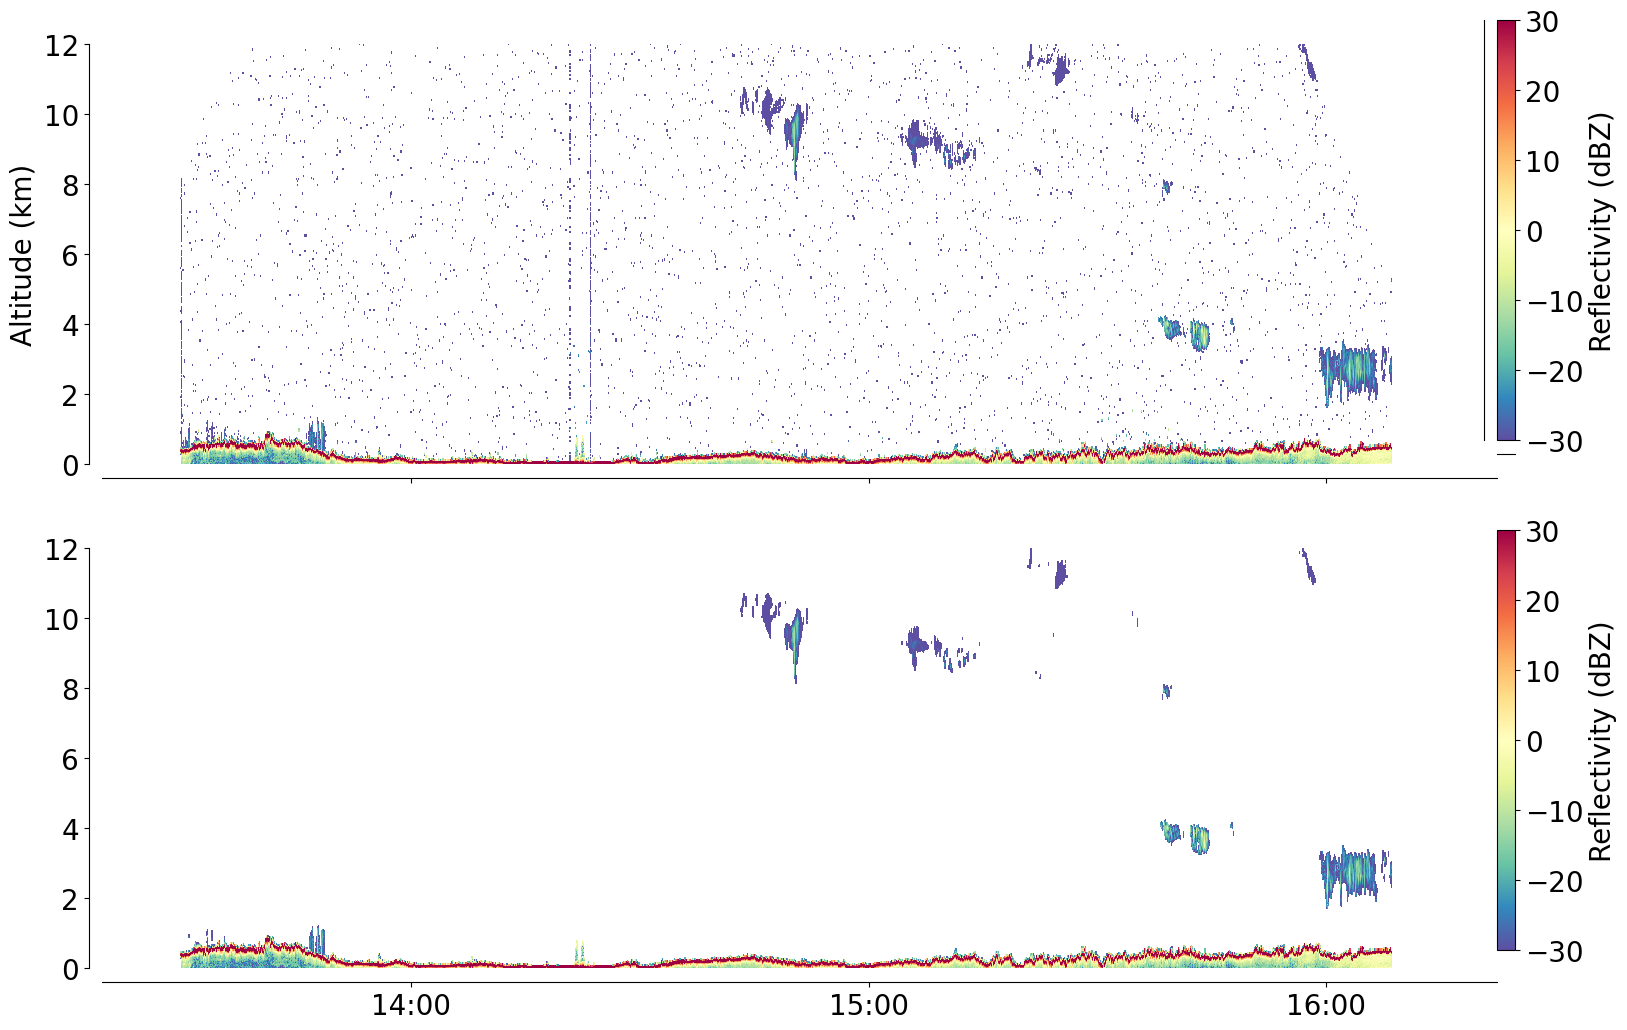

In [32]:
#Radar_Quicklook.plot_radar_clutter_comparison()

In [33]:
compare_calibration=False
Radar_cls.open_processed_radar_data(reflectivity_is_calibrated=False)
uncalib_radar_ds=Radar_cls.processed_radar_ds    
if compare_calibration:
    Radar_cls.open_processed_radar_data(reflectivity_is_calibrated=True)    
    calib_radar_ds=Radar_cls.calib_processed_radar_ds

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radar_unified_*20220311_v0*.nc


In [34]:
Radar_cls.processed_radar_ds
#Radar_cls.open_version_specific_processed_radar_data(version="version_to_open")

<xarray.Dataset>
Dimensions:     (time: 10983, height: 453)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-11T13:19:28 ... 2022-03-11T16:2...
  * height      (height) float64 0.0 30.0 60.0 ... 1.35e+04 1.353e+04 1.356e+04
Data variables:
    dBZg        (time, height) float64 ...
    Zg          (time, height) float64 ...
    LDRg        (time, height) float64 ...
    RMSg        (time, height) float64 ...
    VELg        (time, height) float64 ...
    SNRg        (time, height) float64 ...
    curveFlag   (time) float64 ...
    lat         (time) float64 ...
    lon         (time) float64 ...
    alt         (time) float64 ...
    radar_flag  (time, height) float64 ...
Attributes: (12/13)
    title:                 HAMP measurements on HALO Aircraft duringHALO_AC3
    institute:             Meteorological Institute, Universitaet Hamburg; Ma...
    contact:               henning.dorff@uni-hamburg.de
    source:                HAMP ['radar', 'radiometer']
    flight_date:           20220311
    flight_number:         RF01
    ...                    ...
    comment:               Preliminary data! Uncalibrated Data. Only use for ...
    conventions:           CF-1.6 where applicable
    processing_date:       22/03/2024 16:02:23
    authors:               Dorff, Henning; Ewald, Florian; Hirsch, Lutz;Janse...
    licence:               Creative Commons Attribution NonCommercialShareAli...
    performed_processing:   Entire data gap filled. Clutter removed. Side lob...

Calculate CFAD for HALO Radar Reflectivity
[####################] 100% Plot Radar CFADs
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python\src/raw_radar_cfad_20220311.png


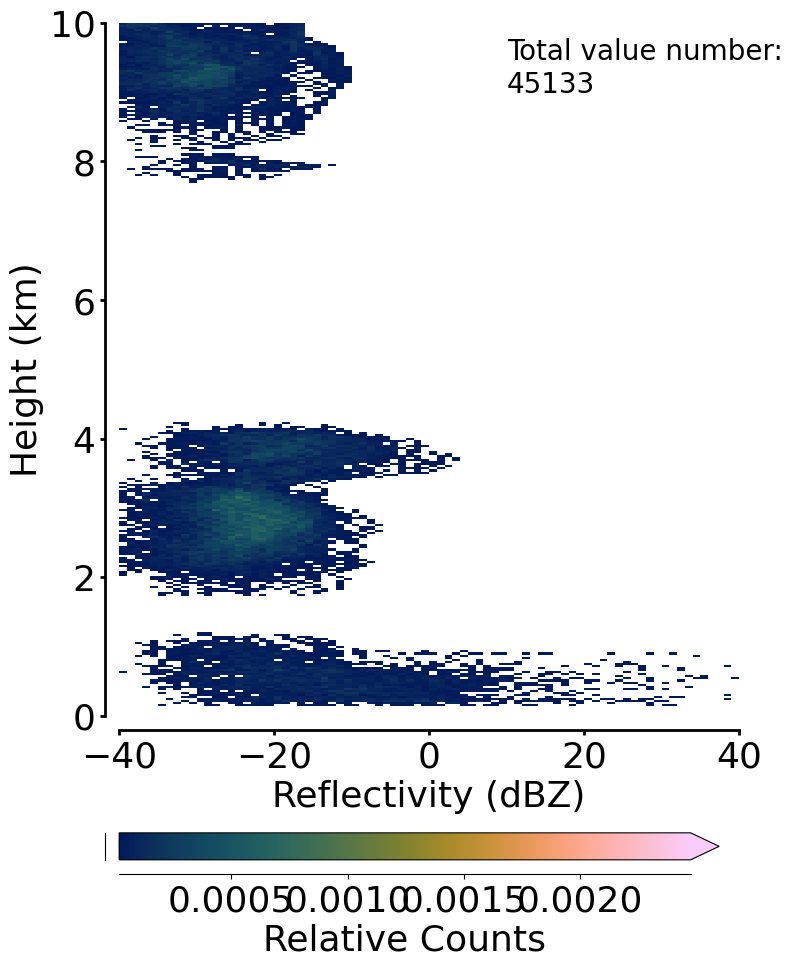

In [35]:
#Radar    
if show_processed_results:
    radar_df=pd.DataFrame(data=np.array(uncalib_radar_ds["dBZg"][:]),
                      index=pd.DatetimeIndex(np.array(uncalib_radar_ds.time[:])),
                      columns=np.array(uncalib_radar_ds["height"][:]))
    Radar_Quicklook.plot_single_radar_cfad(radar_df,raw_measurements=False)
    
    if calibrate_devices:
        calib_radar_df=pd.DataFrame(data=np.array(calib_radar_ds["dBZg"][:].T),
                      index=pd.DatetimeIndex(np.array(uncalib_radar_ds.time[:])),
                      columns=np.array(calib_radar_ds["height"][:]))
        Radar_Quicklook.plot_single_radar_cfad(calib_radar_df,raw_measurements=False,is_calibrated=True)
    

Plotting HAMP Cloud Radar (processed)
dBZ plotted
LDR plotted
mask
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python///Flight_Data/HALO_AC3/plots/radar/processed_radar_quicklook_20220311.png


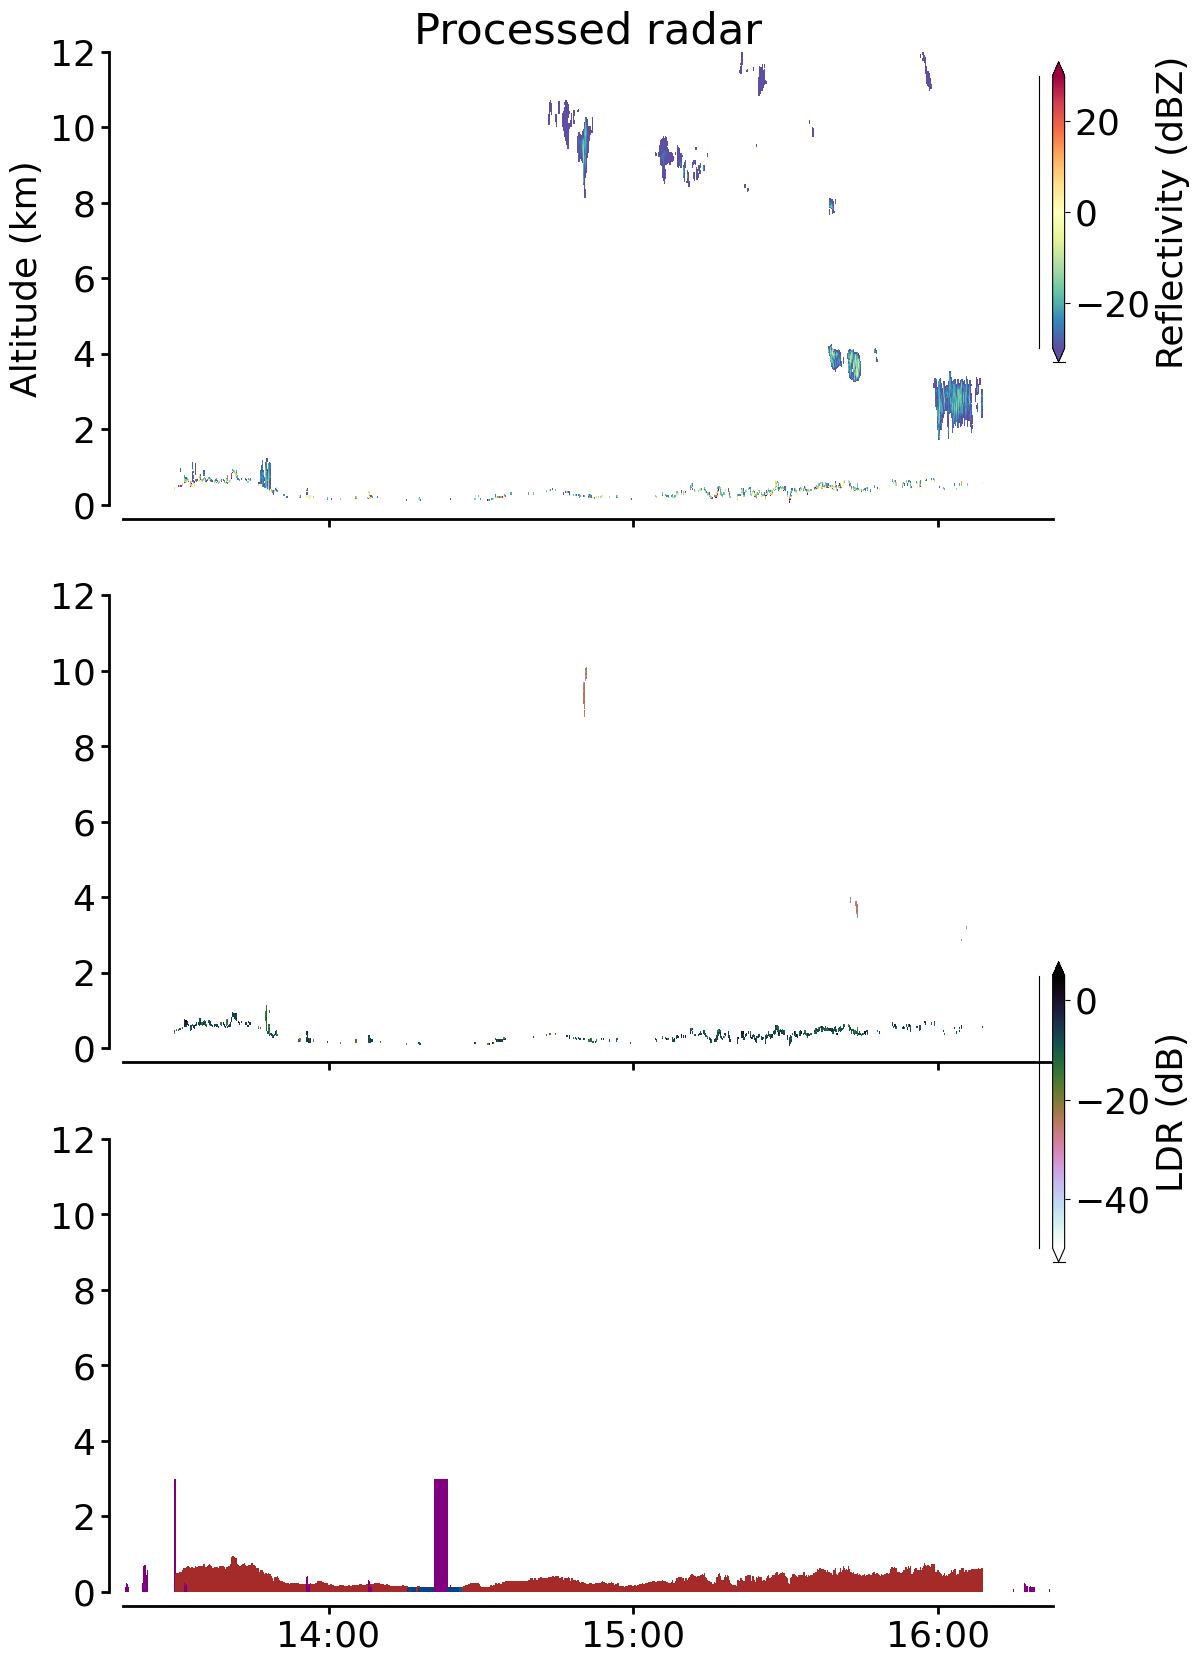

In [36]:
if show_processed_results:
    show_masks=False
    if int(prcs_cfg_dict["subversion"])>4:
        show_masks=True
    Radar_Quicklook.processed_radar_ds=Radar_cls.processed_radar_ds
    Radar_Quicklook.processed_radar_quicklook(is_calibrated=calibrate_devices,show_masks=show_masks)
    
    # ---> do if clause with if show masks and append radar_flag to list

## Processed radiometer

In [36]:
#Radiometer
HAMP_cls.open_processed_hamp_data(open_calibrated=calibrate_devices,newest_version=False)
if not calibrate_devices:
    Radiometer_Quicklook.radiometer_tb_dict=HAMP_cls.processed_hamp_ds
else:
    Radiometer_Quicklook.radiometer_tb_dict=HAMP_cls.calib_processed_hamp_ds
Radiometer_Quicklook.radiometer_tb_dict

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python//Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radiometer_unified_RF01_20220311_v0.6.nc


<xarray.Dataset>
Dimensions:             (time: 10983, uniRadiometer_freq: 25)
Coordinates:
  * time                (time) datetime64[ns] 2022-03-11T13:19:28 ... 2022-03...
  * uniRadiometer_freq  (uniRadiometer_freq) float64 183.9 184.8 ... 56.66 58.0
Data variables:
    TB                  (time, uniRadiometer_freq) float64 ...
    freq                (uniRadiometer_freq) float64 ...
    interpolate_flag    (time, uniRadiometer_freq) float64 ...
    lat                 (time) float64 ...
    lon                 (time) float64 ...
    alt                 (time) float64 ...
    surface_mask        (time) float64 ...
Attributes: (12/13)
    title:                 HAMP measurements on HALO Aircraft duringHALO_AC3
    institute:             Meteorological Institute, Universitaet Hamburg; Ma...
    contact:               henning.dorff@uni-hamburg.de
    source:                HAMP ['radar', 'radiometer']
    flight_date:           20220311
    flight_number:         RF01
    ...                    ...
    comment:               Preliminary data! Uncalibrated Data. Only use for ...
    conventions:           CF-1.6 where applicable
    processing_date:       22/03/2024 15:56:21
    authors:               Dorff, Henning; Ewald, Florian; Hirsch, Lutz;Janse...
    licence:               Creative Commons Attribution NonCommercialShareAli...
    performed_processing:  Gaps filled. Strong flight manoeuvers removed. Rad...

Plotting ...
Figure saved as :  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\hamp_processing_python/../../Work/GIT_Repository/hamp_processing_py/hamp_processing_python///Flight_Data/HALO_AC3/plots/radiometer/HAMP_Tb_RF01_20220311.png


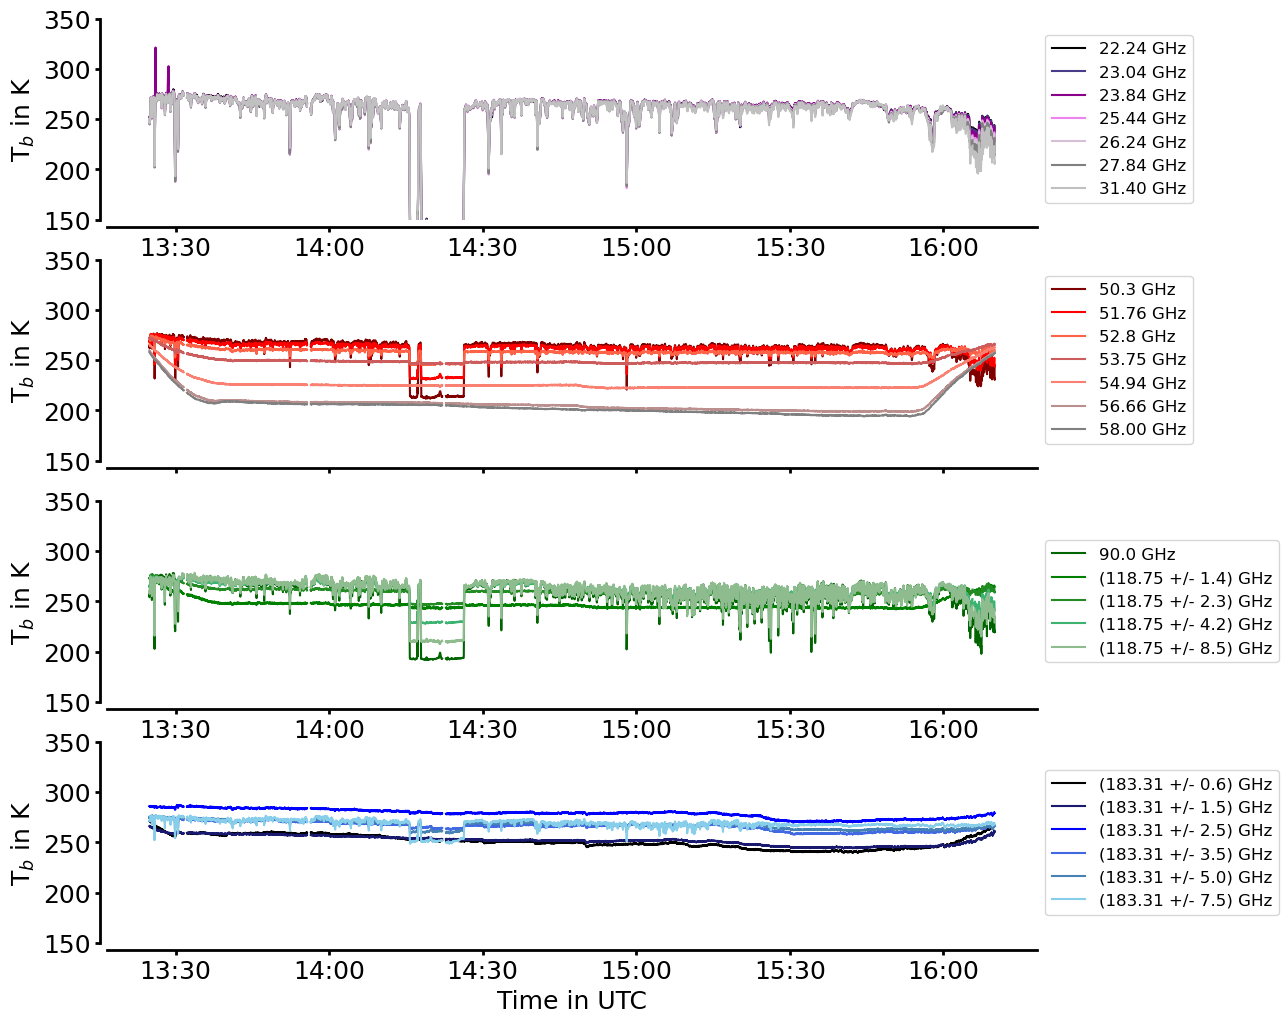

In [37]:
if show_processed_results:
    if calibrate_devices:
        Radiometer_Quicklook.get_HAMP_TB_calibration_coeffs_of_flight()
        Radiometer_Quicklook.plot_radiometer_TB_calibration_comparison()
        print(HAMP_cls.flight_tb_offset_coeff_ds)
        print(HAMP_cls.flight_tb_slope_coeff_ds)
    # Plot the TBs
    Radiometer_Quicklook.plot_radiometer_TBs(raw_measurements=False)  

In [38]:
surface_mask=Radar_cls.processed_radar_ds["radar_flag"]
surface_mask

<xarray.DataArray 'radar_flag' (time: 10983, height: 453)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-11T13:19:28 ... 2022-03-11T16:22:30
  * height   (height) float64 0.0 30.0 60.0 ... 1.35e+04 1.353e+04 1.356e+04

In [39]:
Radar_cls.processed_radar_ds["radar_flag"]

<xarray.DataArray 'radar_flag' (time: 10983, height: 453)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-11T13:19:28 ... 2022-03-11T16:22:30
  * height   (height) float64 0.0 30.0 60.0 ... 1.35e+04 1.353e+04 1.356e+04